In [23]:
import pickle
#import pybedtools
import os

In [24]:
odcf = False
#pc006 = True
if odcf:
    data_dir = "/omics/groups/OE0540/internal/users/mikulik/master_thesis/data/gcs_basenj/"
    from data_utils import * 
    
    
else:
    data_dir = "/data/mikulik/mnt/gcs_basenj/"
    from deepmind_utils import * 

print(data_dir)


# the trained enformer model is available under:
model_path = 'https://tfhub.dev/deepmind/enformer/1'


/data/mikulik/mnt/gcs_basenj/


In [25]:
#specify device cpu, because the model does not fit on the GPU
tf.device('/cpu:0')
SEQUENCE_LENGTH = 393216
TARGET_LENGTH = 896
BIN_SIZE = 128
experiments_human = 5313
experiments_mouse = 1643

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
tf.config.experimental.list_physical_devices('CPU')
tf.device('/CPU:0')


Num GPUs Available:  0
Num CPUs Available:  1


In [27]:
with tf.device("CPU"):
    enformer_model = hub.load("https://tfhub.dev/deepmind/enformer/1").model#, options=tf_obj).model

In [28]:
tf.config.list_physical_devices("CPU")
enformer = Enformer(model_path, "CPU")
tf.config.list_physical_devices("CPU")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Correlations at TSS for CAGE tracks

In [29]:
target_df = pd.read_csv(os.path.join(data_dir, "human", "targets.txt"), sep = "\t")
target_df[["experiment", "descr"]] = target_df.description.str.split(":", n=1, expand=True)
cage_index = target_df["experiment"].str.contains("CAGE")#.index
print(f"There are {cage_index.sum()} CAGE experiments in mouse")

There are 638 CAGE experiments in mouse


In [45]:
def plot_corr_hist(corr_vec, exp="CAGE", model=None, title=None, color="green"):
    #if cross_genes:
    #    index = target_df[target_df["experiment"] == exp].index
    #    sub = corr_vec[index]
    #else:
    #    sub = corr_vec
    sns.histplot(corr_vec, color=color)
    mean_corr = np.round(corr_vec.mean(), decimals=2)
    plt.title(f"{title}, {model},{exp}, mean:{mean_corr:.3f}")
    plt.xlabel("Correlation")
    plt.show()



def plot_cage_corr_comparison(corr_vec1, corr_vec2, x_axis=None, y_axis=None, title=None, per_exp=False, save_pdf=None):
    sns.scatterplot(x=corr_vec1, y=corr_vec2, color="black", s=80)#marker="o", facecolors="none", edgecolor="black")    
    sns.kdeplot(x=corr_vec1, y=corr_vec2, fill=True, alpha=0.6, cmap="Blues") 

    plt.title(f"{title}, Correlation at CAGE TSS, log-transformed counts")
    if per_exp:
        sns.lineplot(x=[-1,1], y=[-1,1], color="black")
        plt.axhline(y=0, color="black", linestyle="--")
        plt.axvline(x=0, color="black", linestyle="--")
        plt.ylim(-1,1)
        plt.xlim(-1,1)
    else:
        sns.lineplot(x=[0.5,1], y=[0.5,1], color="black")
    plt.xlabel(f"{x_axis}, mean:{corr_vec1.mean():.3f}")
    plt.ylabel(f"{y_axis}, mean:{corr_vec2.mean():.3f}")
    if save_pdf != None:
        plt.savefig(os.path.join(save_pdf,  f'{x_axis}_{y_axis}_{title}.pdf'), format='pdf')
    plt.show()


In [31]:
def pearson_corr(x, y, log = True):
    if log:
        x, y = np.log(x + 1), np.log(y + 1)
    assert x.shape == y.shape
    rows, cols = 0, 1
    corr_vec = np.zeros(x.shape[cols]) 
    row, col = x.shape[rows], x.shape[cols]
    for column in range(col):
        a, b = x[:, column], y[:, column]
        corr = np.corrcoef(a, b)[0,1]
        corr_vec[column] = corr
    return corr_vec


# To normalize across genes for each experiment
def standardize_matrix_columns(mat, log=False):
    if log == True:
        mat = np.log(mat + 1)
    norm_mat = (mat - np.mean(mat, axis=0)) / np.std(mat, axis=0)
    # make sure that mean is zero now
    assert np.all(np.isclose(norm_mat.sum(axis=0), 0))
    # make sure that std is one now
    assert np.all(np.std(norm_mat, axis=0)) == 1
    return norm_mat



# get correlation vector across genes or across experiments
def get_corr_from_gene_dict(target_df, data_dir=None, file_name=None, gene_dict=None, per_exp=True, log=True, standardize_exp=True):
    # read from file
    if (data_dir != None) & (file_name!=None):
        with open(os.path.join(data_dir, file_name), "rb") as f:
            gene_dict = pickle.load(f)
        pred, tar = np.array(list(gene_dict["pred"].values())), np.array(list(gene_dict["tar"].values()))
    # read from dict
    elif gene_dict != None:
        pred, tar = np.array(list(gene_dict["pred"].values())), np.array(list(gene_dict["tar"].values()))

    # subset for only CAGE tracks
    index = target_df[target_df["experiment"] == "CAGE"].index
    tar, pred = tar[:, index], pred[:, index]
    print(tar.shape, pred.shape)
    
    if per_exp: 
        print(f"Computing correlation per experiment across genes, log_transforming: {log}")
        corr_vec = pearson_corr(pred, tar, log=log)
    else:
        print(f"Computing correlation per gene across experiments, standardizeing across genes for each experiment first, log-transforming: {log}")
        # standardize for each experiment across genes & log-transform
        if standardize_exp:
            pred, tar = standardize_matrix_columns(pred, log=log), standardize_matrix_columns(tar, log=log)
        corr_vec = pearson_corr(pred.T, tar.T, log=False)
    return corr_vec



### Deepmind correlation across CAGE tracks

Old:

In [32]:
deepmind_corr_gene = get_corr_from_gene_dict(target_df, data_dir=os.path.join(data_dir, "corr_cage_tss"), 
                                             file_name="gene_dict_deepmind_protein_coding_new_alltss_08_04.pkl", 
                                             per_exp=True, log=True)
deepmind_corr_exp = get_corr_from_gene_dict(target_df, data_dir=os.path.join(data_dir, "corr_cage_tss"),
                                            file_name="gene_dict_deepmind_protein_coding_new_alltss_08_04.pkl", 
                                            per_exp=False, log=True)
#deepmind_gene_nolog = get_corr_from_gene_dict(data_dir=os.path.join(data_dir, "correlations"), file_name="gene_dict_deepmind_protein_coding_new_alltss_08_04.pkl", per_exp=True, log=False)
#deepmind_exp_nolog = get_corr_from_gene_dict(data_dir=os.path.join(data_dir, "correlations"), file_name="gene_dict_deepmind_protein_coding_new_alltss_08_04.pkl", per_exp=False, log=False)
#deepmind_exp_nost = get_corr_from_gene_dict(data_dir=os.path.join(data_dir, "correlations"), file_name="gene_dict_deepmind_protein_coding_new_alltss_08_04.pkl", per_exp=False, log=True, standardize_exp=False)
deepmind_corr_gene_protein = get_corr_from_gene_dict(target_df, data_dir=os.path.join(data_dir, "corr_cage_tss"),
                                                      file_name="gene_dict_deepmind_protein_coding_new_protein_coding_08_04.pkl", 
                                                      per_exp=True, log=True)
deepmind_corr_exp_protein = get_corr_from_gene_dict(target_df, data_dir=os.path.join(data_dir, "corr_cage_tss"), 
                                                    file_name="gene_dict_deepmind_protein_coding_new_protein_coding_08_04.pkl",
                                                      per_exp=False, log=True)



(5877, 638) (5877, 638)
Computing correlation per experiment across genes, log_transforming: True
(5877, 638) (5877, 638)
Computing correlation per gene across experiments, standardizeing across genes for each experiment first, log-transforming: True
(1902, 638) (1902, 638)
Computing correlation per experiment across genes, log_transforming: True
(1902, 638) (1902, 638)
Computing correlation per gene across experiments, standardizeing across genes for each experiment first, log-transforming: True


## Small model


In [33]:
from cage_correlations_across_experiment import *

data_dir = "/data/mikulik/mnt/gcs_basenj/"

# small model trained for month
obj = CageCorr(data_dir=os.path.join(data_dir, "corr_cage_tss"), train="enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_overlap_train_protein_coding_train_human_gene_dict.pkl",
                       test="enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_overlap_test_protein_coding_test_human_gene_dict.pkl",
                       valid="enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_overlap_valid_protein_coding_valid_human_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"))
corr_small_model_protein_coding_tss = obj.across_gene_correlation("test")
corr_small_model_protein_coding_tss_exp = obj.across_experiment_correlation("test")
print(corr_small_model_protein_coding_tss.mean())
print(corr_small_model_protein_coding_tss_exp.mean())


# small model trained with batch size 12
obj = CageCorr(data_dir=os.path.join(data_dir, "corr_cage_tss"), train="enf_train_v2_batch_12_lr_1e4_training_state_dict_overlap_train_protein_coding_train_human_gene_dict.pkl",
                       test="enf_train_v2_batch_12_lr_1e4_training_state_dict_overlap_test_protein_coding_test_human_gene_dict.pkl",
                       valid="enf_train_v2_batch_12_lr_1e4_training_state_dict_overlap_valid_protein_coding_valid_human_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"))
corr_small_gene= obj.across_gene_correlation("test")
corr_small_exp = obj.across_experiment_correlation("test")
print(corr_small_gene.mean())
print(corr_small_exp.mean())

Compute correlation across genes for test
Compute correlation across experiments for test
0.8265817224584846
0.4216734695755557
Compute correlation across genes for test
Compute correlation across experiments for test
0.7958525182132604
0.40007285007527793


### Comparing two small model versions

One was trained with the linear layer in the transformer block and for a month: enf_train_v2_batch_2_lr_1e3_linear_noit_0

The other one was trained without the linear layer and shorter: enf_train_v2_batch_12_lr_1e4

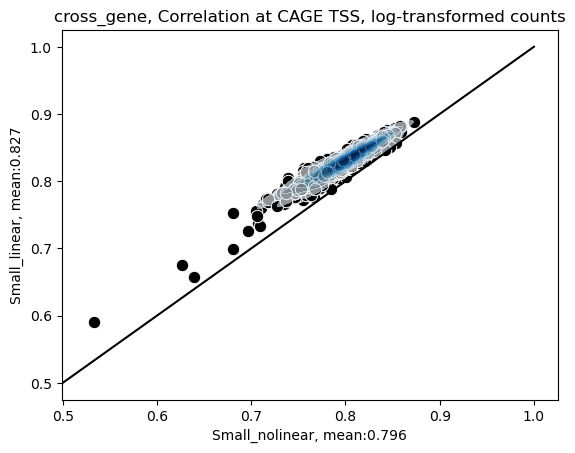

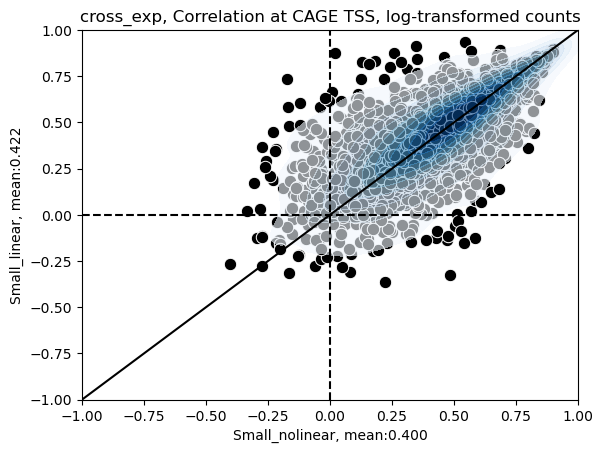

In [47]:
plot_cage_corr_comparison(corr_small_gene, corr_small_model_protein_coding_tss,  
                          x_axis="Small_nolinear", y_axis="Small_linear", title="cross_gene",
                          save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(corr_small_exp, corr_small_model_protein_coding_tss_exp, 
                             x_axis="Small_nolinear", y_axis="Small_linear", 
                             per_exp=True, title="cross_exp",
                          save_pdf=os.path.join(data_dir, "plots"))

### contrasting Deepmind Enformer with small Enformer

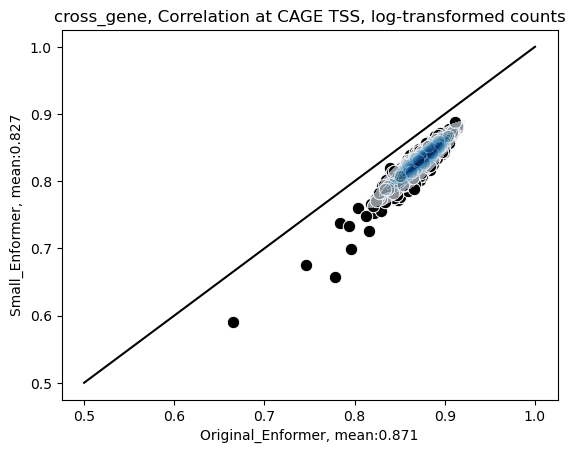

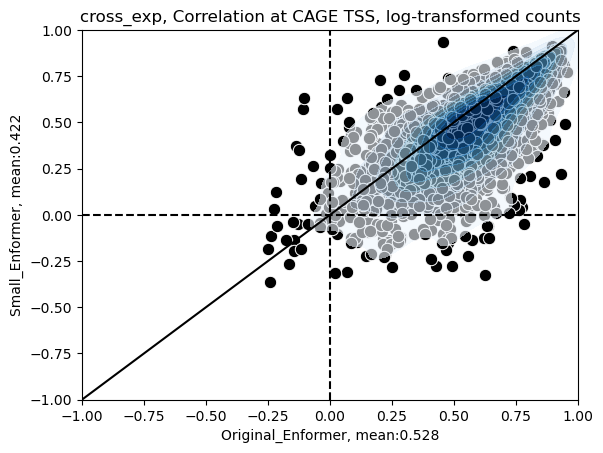

In [48]:
plot_cage_corr_comparison(deepmind_corr_gene_protein, corr_small_model_protein_coding_tss,
                          x_axis="Original_Enformer", y_axis="Small_Enformer", title="cross_gene",
                          save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(deepmind_corr_exp_protein, corr_small_model_protein_coding_tss_exp,
                             x_axis="Original_Enformer", y_axis="Small_Enformer", 
                             per_exp=True, title="cross_exp",
                          save_pdf=os.path.join(data_dir, "plots"))

# Collecting CAGE counts at TSS:


# Basenji


Was this for only protein-coding genes?

Is it correct that I log-transform the counts after aggregating them per TSS?

In [49]:
data_dir = "/data/mikulik/mnt/gcs_basenj"
obj = CageCorr(data_dir=os.path.join(data_dir, "corr_cage_tss"), train="basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_overlap_train_protein_coding_train_human_gene_dict.pkl",
                       test="basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_overlap_test_protein_coding_test_human_gene_dict.pkl",
                       valid="basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_overlap_valid_protein_coding_valid_human_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"))
corr_basenji_protein_coding_tss_gene = obj.across_gene_correlation("test")
corr_basenji_protein_coding_tss_exp = obj.across_experiment_correlation("test")



Compute correlation across genes for test
Compute correlation across experiments for test


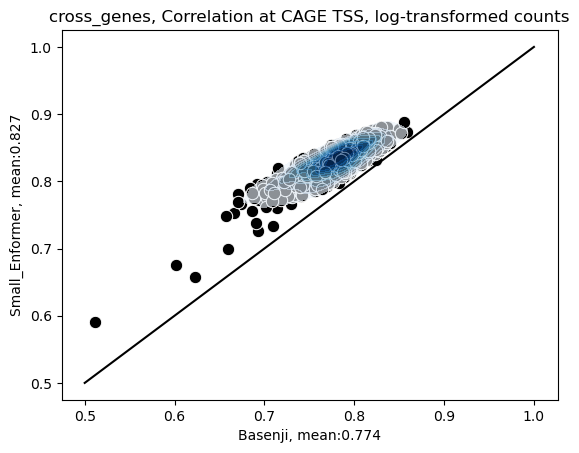

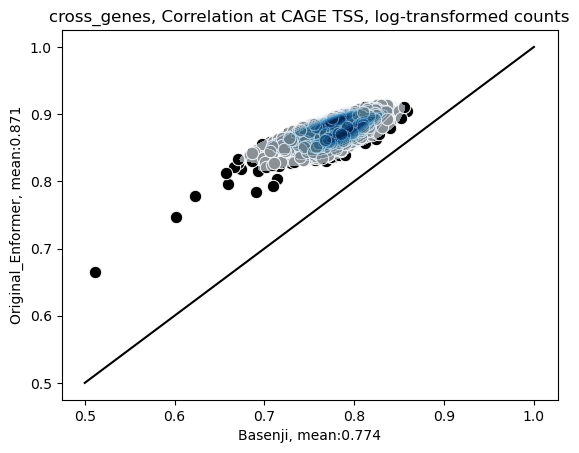

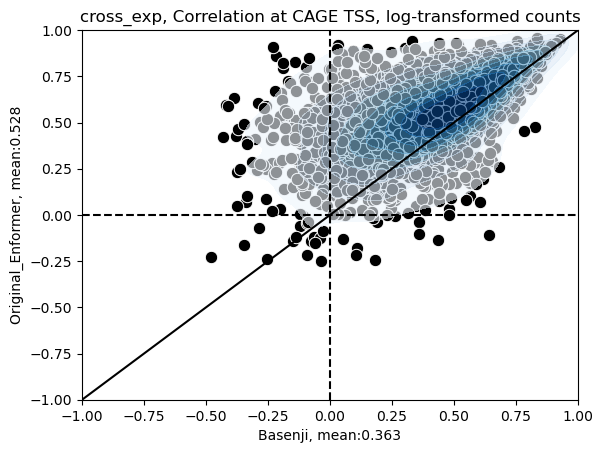

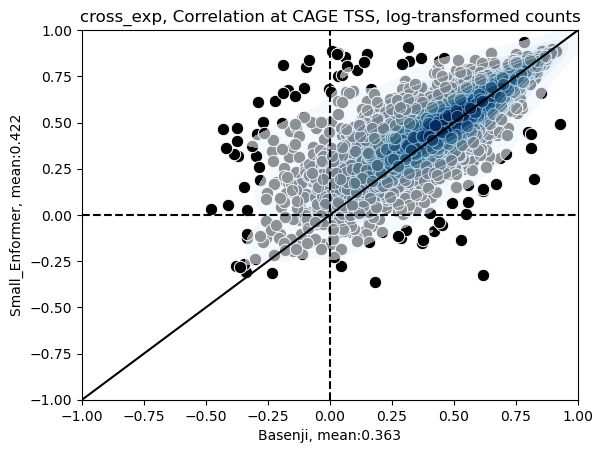

In [50]:
#plot_cage_corr_comparison(corr_basenji_all_tss_gene, corr_basenji_protein_coding_tss_gene, x_axis="Basenji, across all tss", y_axis="Basenji, across protein-coding tss", color="darkred")
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_gene, corr_small_model_protein_coding_tss, 
                          x_axis="Basenji", y_axis="Small_Enformer", title="cross_genes", 
                          save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_gene, deepmind_corr_gene_protein,
                           x_axis="Basenji", y_axis="Original_Enformer", title="cross_genes", 
                            save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_exp, deepmind_corr_exp_protein, per_exp=True,
                          x_axis="Basenji", y_axis="Original_Enformer", title="cross_exp", 
                           save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_exp, corr_small_model_protein_coding_tss_exp,per_exp=True,
                          x_axis="Basenji", y_axis="Small_Enformer", title="cross_exp", 
                            save_pdf=os.path.join(data_dir, "plots"))

### Basenji debug


In [51]:
obj = CageCorr(data_dir=os.path.join(data_dir, "corr_cage_tss"), train="basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_overlap_train_protein_coding_train_human_gene_dict.pkl",
                       test="basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_overlap_test_protein_coding_test_human_gene_dict.pkl",
                       valid="basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_overlap_valid_protein_coding_valid_human_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"))
basenji_gene_debug = obj.across_gene_correlation("test")
basenji_exp_debug = obj.across_experiment_correlation("test")



Compute correlation across genes for test
Compute correlation across experiments for test


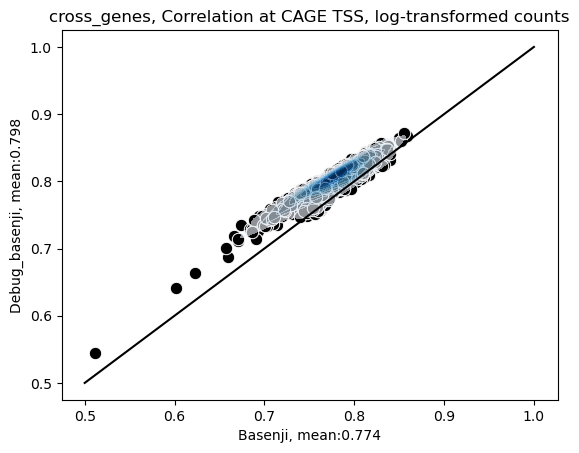

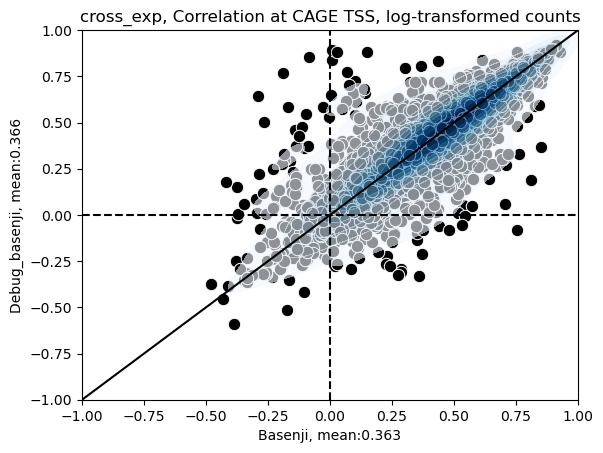

In [52]:

#plot_cage_corr_comparison(corr_basenji_all_tss_gene, corr_basenji_protein_coding_tss_gene, x_axis="Basenji, across all tss", y_axis="Basenji, across protein-coding tss", color="darkred")
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_gene, basenji_gene_debug, 
                          x_axis="Basenji", y_axis="Debug_basenji", title="cross_genes", 
                          save_pdf=os.path.join(data_dir, "plots"))

plot_cage_corr_comparison(corr_basenji_protein_coding_tss_exp, basenji_exp_debug, per_exp=True,
                          x_axis="Basenji", y_axis="Debug_basenji", title="cross_exp", 
                           save_pdf=os.path.join(data_dir, "plots"))


### Basenji Residual connection

In [53]:
obj = CageCorr(data_dir=os.path.join(data_dir, "corr_cage_tss"), 
                        test="basenji_res_con_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_overlap_test_protein_coding_test_human_gene_dict.pkl",
                       train="basenji_res_con_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_overlap_train_protein_coding_train_human_gene_dict.pkl",
                       valid="basenji_res_con_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_overlap_valid_protein_coding_valid_human_gene_dict.pkl")
pred, tar = obj.normalize_gene_mat(target_df_dir=os.path.join(data_dir, "human", f"targets.txt"))
basenji_gene_res= obj.across_gene_correlation("test")
basenji_exp_res = obj.across_experiment_correlation("test")



Compute correlation across genes for test
Compute correlation across experiments for test


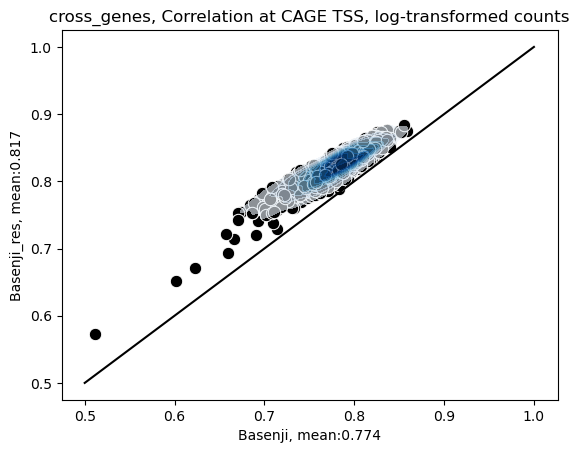

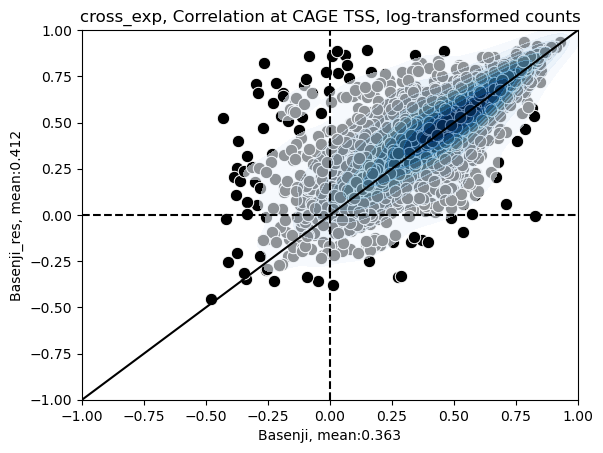

In [54]:
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_gene, basenji_gene_res, 
                          x_axis="Basenji", y_axis="Basenji_res", title="cross_genes", 
                          save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(corr_basenji_protein_coding_tss_exp, basenji_exp_res, per_exp=True,
                          x_axis="Basenji", y_axis="Basenji_res", title="cross_exp", 
                           save_pdf=os.path.join(data_dir, "plots"))


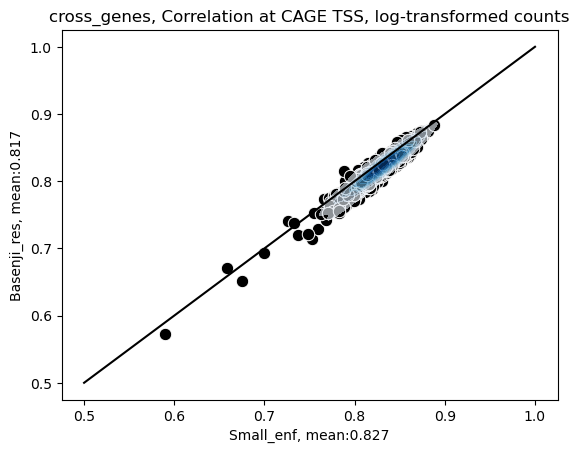

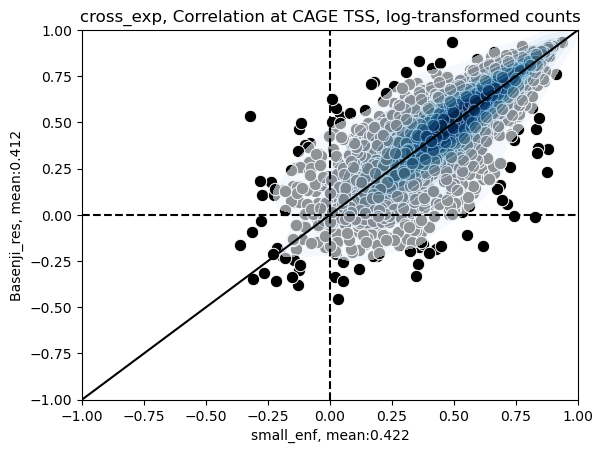

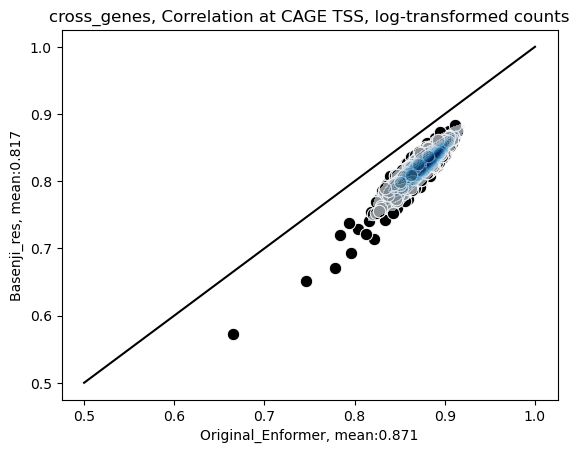

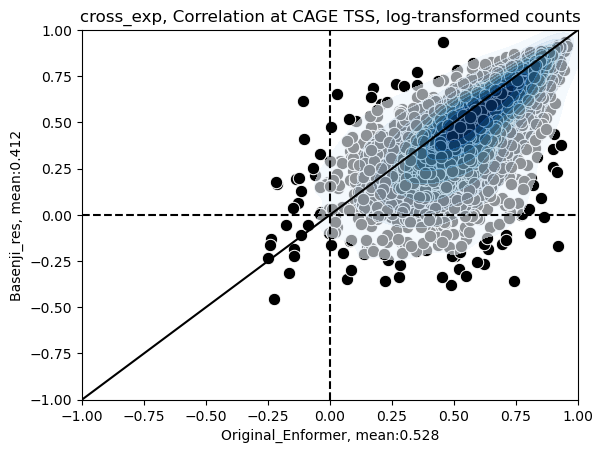

In [55]:
plot_cage_corr_comparison(corr_small_model_protein_coding_tss, basenji_gene_res, 
                          x_axis="Small_enf", y_axis="Basenji_res", title="cross_genes", 
                          save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(corr_small_model_protein_coding_tss_exp, basenji_exp_res, per_exp=True,
                          x_axis="small_enf", y_axis="Basenji_res", title="cross_exp", 
                           save_pdf=os.path.join(data_dir, "plots"))


plot_cage_corr_comparison(deepmind_corr_gene_protein, basenji_gene_res, 
                          x_axis="Original_Enformer", y_axis="Basenji_res", title="cross_genes", 
                          save_pdf=os.path.join(data_dir, "plots"))
plot_cage_corr_comparison(deepmind_corr_exp_protein, basenji_exp_res, per_exp=True,
                          x_axis="Original_Enformer", y_axis="Basenji_res", title="cross_exp", 
                           save_pdf=os.path.join(data_dir, "plots"))